In [9]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.sparse as sp

## Parameters

In [10]:
horizon = 480 #5 days, 15-min intervals

In [11]:
# Create a model: Automatic Demand Response (ADR)
model = gp.Model("ADR") 

Restricted license - for non-production use only - expires 2025-11-24


## Data Loading

### Electricity demand

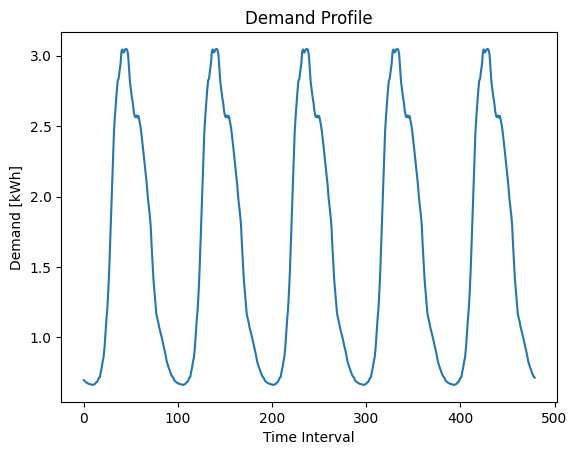

In [12]:
profile_demand = pd.read_csv('Demand_Data_15min.csv', sep=',', decimal='.')
facteur = 50000/1000000
real_Demand= profile_demand['Demand']*facteur
Critical_Demand= np.array(real_Demand)

#plot the Demand Column
plt.plot(real_Demand)
plt.title('Demand Profile')
plt.xlabel('Time Interval')
plt.ylabel('Demand [kWh]')
plt.show()


### Electricity price loading

2024-04-07 00:00:00,0.2216
2024-04-07 00:15:00,0.2216
2024-04-07 00:30:00,0.2216
2024-04-07 00:45:00,0.2216
2024-04-07 01:00:00,0.2216
2024-04-07 01:15:00,0.2216
2024-04-07 01:30:00,0.2216
2024-04-07 01:45:00,0.2216
2024-04-07 02:00:00,0.2216
2024-04-07 02:15:00,0.2216
2024-04-07 02:30:00,0.2216
2024-04-07 02:45:00,0.2216
2024-04-07 03:00:00,0.2216
2024-04-07 03:15:00,0.2216
2024-04-07 03:30:00,0.2216
2024-04-07 03:45:00,0.2216
2024-04-07 04:00:00,0.2216
2024-04-07 04:15:00,0.2216
2024-04-07 04:30:00,0.2216
2024-04-07 04:45:00,0.2216
2024-04-07 05:00:00,0.2216
2024-04-07 05:15:00,0.2216
2024-04-07 05:30:00,0.2216
2024-04-07 05:45:00,0.2216
2024-04-07 06:00:00,0.2216
2024-04-07 06:15:00,0.2216
2024-04-07 06:30:00,0.2216
2024-04-07 06:45:00,0.2216
2024-04-07 07:00:00,0.32520000000000004
2024-04-07 07:15:00,0.32520000000000004
2024-04-07 07:30:00,0.32520000000000004
2024-04-07 07:45:00,0.32520000000000004
2024-04-07 08:00:00,0.32520000000000004
2024-04-07 08:15:00,0.32520000000000004
2024

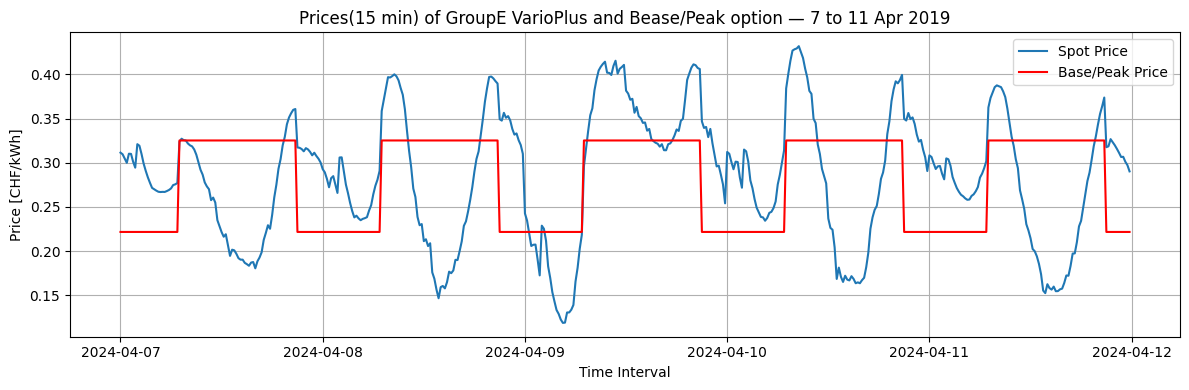

In [13]:
spot_prices = pd.read_csv('VarioPlus_2019-04-07_to_2019-04-11_15min.csv',parse_dates=['time'],index_col='time')
spot_prices['price'] = spot_prices['price'] / 100 #conversion from cts/kWh to CHF/kWh
base_price = 22.16/100 #in CHF/kWh with TVA
peak_price = 32.52/100 #in CHF/kWh with TVA

#create an array called Base_Peak_price where price from 7 to 21 is Peak Price and base otherwise 
start = spot_prices.index[0]
rng = pd.date_range(start, periods=horizon, freq='15T')
prices = [ peak_price if 7 <= ts.hour < 21 else base_price for ts in rng ]

Base_Peak_price_df = (pd.DataFrame({'price': prices}, index=rng) ) #dataframe with price for printing correctly
Base_Peak_price = list(zip(rng, prices))#tupple with time and price for the model to ensure smooth operation with edo's modifications
for t, p in Base_Peak_price:
    print(f"{t},{p}")

plt.figure(figsize=(12, 4))
plt.plot(spot_prices.index, spot_prices['price'],label='Spot Price')
plt.plot(Base_Peak_price_df.index, Base_Peak_price_df['price'], label='Base/Peak Price', color='red')

plt.title('Prices(15 min) of GroupE VarioPlus and Bease/Peak option — 7 to 11 Apr 2019')
plt.xlabel('Time Interval')
plt.ylabel('Price [CHF/kWh]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

spot_prices = np.array(spot_prices['price']) # convert to an array

In [14]:
print(spot_prices[0:10])

[0.3114 0.3096 0.3048 0.2999 0.3102 0.31   0.3011 0.2944 0.321  0.3192]


### Temperature loading

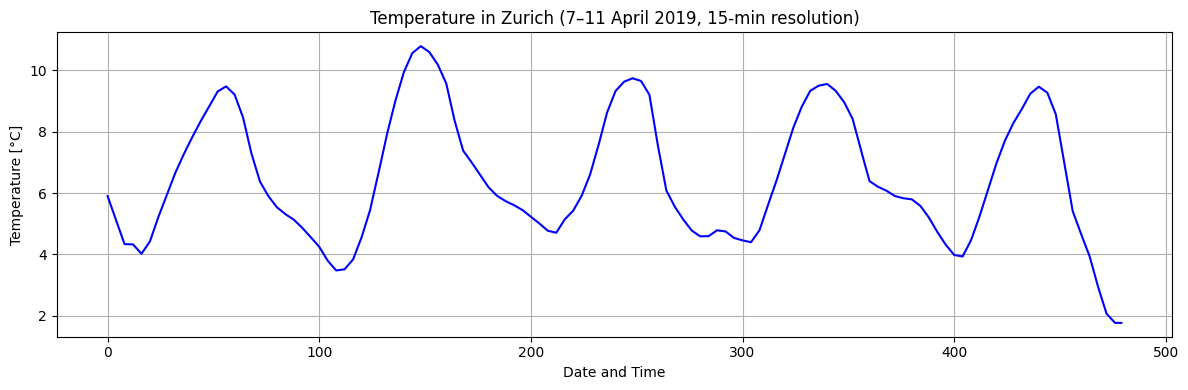

In [15]:
# i import and display Temperature_Data_Zurich_15min.csv
temperature_data = pd.read_csv('Temperature_Data_Zurich_15min.csv', parse_dates=['time'])
# Plot the temperature (°C) at 15-minute intervals
plt.figure(figsize=(12, 4))
plt.plot(temperature_data.index, temperature_data['temperature'], color='blue')
plt.title('Temperature in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
temperature_data.head()

,time,temperature
0,2019-04-07 00:00:00,5.9010
1,2019-04-07 00:15:00,5.7065
2,2019-04-07 00:30:00,5.5120
3,2019-04-07 00:45:00,5.3175
4,2019-04-07 01:00:00,5.1230


### Solar irradiance

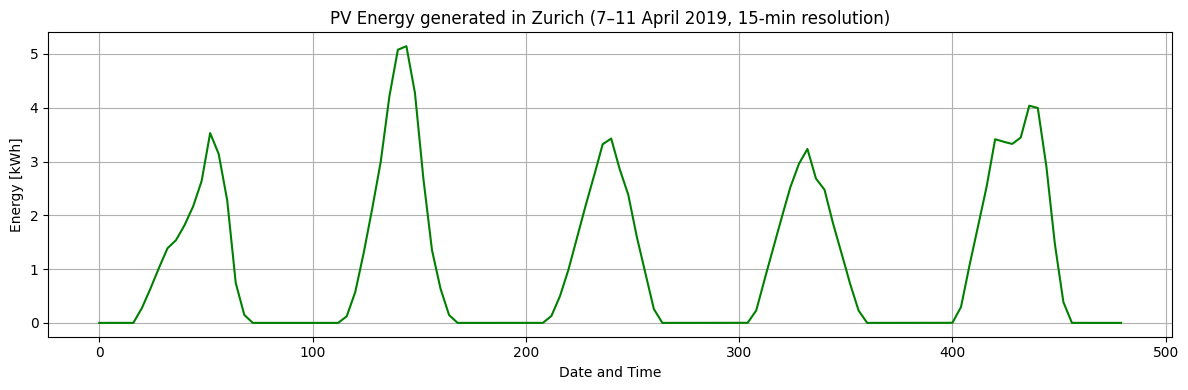

In [17]:
solar_energy = pd.read_csv('Solar_Energy_Zurich_15min.csv') #kWh/m²
PV_area = 200 # m²
PV_efficiency = 0.2 # 20% efficiency
PV_elec = solar_energy['Energy [kWh/m²]'] * PV_area * PV_efficiency # kWh
PV_elec = np.array(PV_elec)

# Plot the solar energy (kWh) at 15-minute intervals
plt.figure(figsize=(12, 4))
plt.plot(solar_energy.index, PV_elec, color='green')
plt.title('PV Energy generated in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Energy [kWh]')
plt.grid(True)
plt.tight_layout()
plt.show()  


## Modelling 

### EVs:

In [18]:
# --- PARAMETERS ---
n_evs        = 15          # number of EVs
P_rated      = 4.0         # kW, max charger power
E_req        = 6.0         # kWh, daily depleted energy of 6 kWh per EV
dt           = 0.25        # hours per time slot (15 min ⇒ 0.25 h)
T_day        = 96          # total 15-min slots per day
days         = 5           # number of days
start_idx    = 9 * 4       # 9:00 → slot 36
end_idx      = 18 * 4      # 18:00 → slot 72 (exclusive upper bound)
# index sets
evs = range(n_evs) 
slots = range(T_day)
days_ = range(days)

# continuous variable p[e,t] ∈ [0, P_rated] = charging power of EV e in slot t (kW)
p = model.addVars(evs, days, slots, #create set of decision variables, indexed by EVs, time slots and day
            #each variable p[e, t] corresponds to the charging power of EV e during time slot t in kW
            vtype=GRB.CONTINUOUS,
            lb=0.0, # lower bound of the variable
            ub=P_rated, # upper bound of the variable, P_rated is the maximum charging power
            name="p") #base name of the variable

# 1) Energy requirement: each EV must accumulate E_req kWh over the allowed window
for e in evs:
    for d in days_:
        model.addConstr(
            gp.quicksum(p[e,d,t] * dt for t in range(start_idx, end_idx)) == E_req,
            name=f"energy_e{e}_d{d}"
        )

# 2) Enforce zero charging outside [9:00,18:00), each day.
for e in evs:
    for d in days_:
        # before 9:00
        for t in range(0, start_idx):
            model.addConstr(p[e,d,t] == 0,
                        name=f"zero_before_e{e}_d{d}_t{t}")
        # after 18:00
        for t in range(end_idx, T_day):
            model.addConstr(p[e,d,t] == 0,
                        name=f"zero_after_e{e}_d{d}_t{t}")

# (the ub=P_rated on p already enforces p[e,t] ≤ P_rated for all t)

# 3) Total cost of charging: 
total_cost_EV = gp.LinExpr() #important to define the total cost as a gurobi linear expression!

for e in evs:
    for d in days_:
        for t in slots:
            index = d * T_day + t  # flat index into spot_price
            price = spot_prices[index]  # CHF per kWh
            total_cost_EV += p[e, d, t] * price * dt

print("Total cost of EV:")
print(total_cost_EV)

Total cost of EV:
0.07785 <gurobi.Var *Awaiting Model Update*> + 0.0774 <gurobi.Var *Awaiting Model Update*> + 0.0762 <gurobi.Var *Awaiting Model Update*> + 0.074975 <gurobi.Var *Awaiting Model Update*> + 0.07755 <gurobi.Var *Awaiting Model Update*> + 0.0775 <gurobi.Var *Awaiting Model Update*> + 0.075275 <gurobi.Var *Awaiting Model Update*> + 0.0736 <gurobi.Var *Awaiting Model Update*> + 0.08025 <gurobi.Var *Awaiting Model Update*> + 0.07980000000000001 <gurobi.Var *Awaiting Model Update*> + 0.07745 <gurobi.Var *Awaiting Model Update*> + 0.074725 <gurobi.Var *Awaiting Model Update*> + 0.072675 <gurobi.Var *Awaiting Model Update*> + 0.07085 <gurobi.Var *Awaiting Model Update*> + 0.0693 <gurobi.Var *Awaiting Model Update*> + 0.06787499999999999 <gurobi.Var *Awaiting Model Update*> + 0.067475 <gurobi.Var *Awaiting Model Update*> + 0.06709999999999999 <gurobi.Var *Awaiting Model Update*> + 0.066775 <gurobi.Var *Awaiting Model Update*> + 0.0667 <gurobi.Var *Awaiting Model Update*> + 0.0667

### Additive Manufacturing (AM) Machines

In [19]:
# Parameters
n_AMM = 5 # number of AM machines
AMM = range(n_AMM) # index set for AM machines
power_AMM = 2.76  # Power consumption of each printer in kW

# Full cycle of a printer corresponds to 4 hours of operation (or 16 slots of 15 minutes)
D = 16

# Decision variable, x[m,t] = 1 if machine m starts a job at time t
x = model.addVars(n_AMM,horizon,vtype=GRB.BINARY,name='start')

# Prevent overlapping jobs on the same machine: Ensures machine m can't start two jobs too close together
for m in AMM:
    for t1 in range(horizon - D + 1):
        for t2 in range(t1 + 1, min(t1 + D, horizon - D + 1)):
            model.addConstr(x[m, t1] + x[m, t2] <= 1,
                            name=f"no_overlap_m{m}_t{t1}_t{t2}")

# Last feasible time to start

# Every week, 47 pieces must be produced
model.addConstr(
    gp.quicksum(x[m, t] for m in AMM for t in range(horizon - D + 1)) >= 47,
    name="min_production"
)

# Add a power constraint for every time slot t using only x as indicator.
running = model.addVars(horizon, vtype=GRB.CONTINUOUS, name='running')
for t in range(horizon):
    running[t]= gp.quicksum(
        x[m, s]
        for m in AMM
        for s in range(max(0, t - D + 1), min(t + 1, horizon - D + 1))
    )



# total cost of the AM machines
cost_AMM = gp.quicksum(x[m, t] * sum(spot_prices[t] for t in range(t,t+D)) * power_AMM * dt for m in AMM for t in range(horizon - D + 1))

### Heating demand

In [225]:
# --- PARAMETERS FOR THERMAL MODEL ---
COP_h = 2.5               # Heating COP
COP_c = 2.5               # Cooling COP
inertia = 0.98            # Inertia factor ϵ
A_th = 2.0                # Thermal conductivity [kW/°C]
T_desired = 19.0          # Setpoint temperature [°C]
dead_band = 2.0           # ± dead-band [°C]
T_lower = T_desired - dead_band  # Lower comfort limit (17°C)
T_upper = T_desired + dead_band  # Upper comfort limit (21°C)

# Initial indoor temperature (set here at the lower bound, can be modified)
T_0 = T_lower

# Use the outside temperature from your temperature_data; ensure the ordering/matching with time steps.
T_out = temperature_data['temperature'].values

N = horizon               # Total number of intervals 

# Define working hours mask (09:00–18:00); T_set is used only to indicate working hours
mask_work = (temperature_data['time'].dt.hour >= 9) & (temperature_data['time'].dt.hour < 18)
T_set = np.full(horizon, np.nan)
T_set[mask_work.values] = T_desired

# Compute effective heating and cooling coefficients:
alpha_h = (1 - inertia) * (COP_h / A_th)   # Effect of additional heating
alpha_c = (1 - inertia) * (COP_c / A_th)   # Effect of additional cooling

# Decision variables:
# Define p_h for heating power and p_c for cooling power.
# Here, the space heater is sized at 40 kW; you might set a similar bound for cooling.
p_h = model.addVars(horizon, lb=0.0, ub=40.0, name="p_heat")
p_c = model.addVars(horizon, lb=0.0, ub=40.0, name="p_cool")

# Indoor temperature state variables:
T_in = model.addVars(horizon, lb=-GRB.INFINITY, name="T_in")
model.addConstr(T_in[0] == T_0, name="init_temp")

# Thermal dynamics constraint:
# T_in[k+1] = inertia * T_in[k] + (1 - inertia) * T_out[k] + (alpha_h * p_h[k]) - (alpha_c * p_c[k])
for k in range(N-1):
    model.addConstr(
        T_in[k+1] == inertia * T_in[k] + (1 - inertia) * T_out[k] + alpha_h * p_h[k] - alpha_c * p_c[k],
        name=f"dyn_{k}"
    )

# Comfort constraints (only enforced during working hours):
# Ensure that T_in stays within [T_lower, T_upper] (i.e. within ±2°C of 19°C)
for k in range(N):
    if not np.isnan(T_set[k]):
        model.addConstr(T_in[k] >= T_lower, name=f"min_comfort_{k}")
        model.addConstr(T_in[k] <= T_upper, name=f"max_comfort_{k}")

# Energy consumption of the heating and cooling systems using spot prices
cost_HC = gp.quicksum((p_h[k] + p_c[k]) * dt * spot_prices[k] for k in range(horizon))

### Power threslhold

In [ ]:
# Power threshold constraints
for t in range(horizon):
    model.addConstr(
        power_AMM * running[t] + p_h[t] + p_c[t] <= 20,
        name=f"power_limit_{t}")

# add EV power consumption to the total power consumption

### Objective function

In [3]:
def objective_function(prices, Critical_Demand,cost_AMM, cost_HC,total_cost_EV):
        # Add a constant term to the model objective: models the critical appliances
    total_cost_critical = gp.LinExpr() #important to define the total cost as a gurobi linear expression!
    for t in range(480):
        total_cost_critical += Critical_Demand[t] * prices[t]
    total_cost_week = total_cost_EV + cost_AMM + cost_HC + total_cost_critical 
    return total_cost_week

    total_spot_cost_week = objective_function(spot_prices, Critical_Demand,cost_AMM, cost_HC,total_cost_EV)
    total_BasePeak_cost_week =objective_function(Base_Peak_price, Critical_Demand,cost_AMM, cost_HC,total_cost_EV)
    model.setObjective(total_BasePeak_cost_week, GRB.MINIMIZE)
    # Solve the model, i.e. minimize the cost
    model.write('out.lp')
    model.optimize()

In [4]:
## ENERGY CONSUMPTION CALCULATION BY CATEGORY
total_energy_kWh = 0.0

# EV charging
energy_ev = sum(p[e, d, t].X * dt for e in evs for d in days_ for t in slots)
total_energy_kWh += energy_ev

# AM machines
energy_am = sum(x[m, t].X * power_AMM * D * dt for m in AMM for t in range(horizon - D + 1))
total_energy_kWh += energy_am

# Heating and cooling
energy_heat = sum(p_h[k].X * dt for k in range(horizon - 1))
energy_cool = sum(p_c[k].X * dt for k in range(horizon - 1))
total_energy_kWh += energy_heat + energy_cool

# Critical appliances (already in kWh)
energy_critical = np.sum(Critical_Demand)
total_energy_kWh += energy_critical

# Final output
print(f" Total energy consumed during the week: {total_energy_kWh:.2f} kWh")
print(f"  - EV Charging:     {energy_ev:.2f} kWh")
print(f"  - AM Machines:     {energy_am:.2f} kWh")
print(f"  - Heating:         {energy_heat:.2f} kWh")
print(f"  - Cooling:         {energy_cool:.2f} kWh")
print(f"  - Critical Loads:  {energy_critical:.2f} kWh")

NameError: name 'evs' is not defined

In [5]:
## PRICE CALCULATION BY CATEGORY
print(" Weekly Cost Breakdown (CHF):")
print(f"  - EV Charging:     CHF {total_cost_EV.getValue():.2f}")
print(f"  - AM Machines:     CHF {cost_AMM.getValue():.2f}")
print(f"  - Heating/Cooling: CHF {cost_HC.getValue():.2f}")
print(f"  - Critical Loads:  CHF {total_spot_cost_critical.getValue():.2f}")
print(f"  -----------------------------")
print(f"  Total Costs from Objective function: CHF {model.ObjVal:.2f}")

 Weekly Cost Breakdown (CHF):


NameError: name 'total_cost_EV' is not defined

In [6]:
# print values of the decision variable 

print("x[m,t]:")
#m=0
i=0
#initialize an empty list of dimension (1,20)
time_travel = np.zeros(20) # Initialize an array to store the time values

for m in AMM:
    for t in range(horizon):
        if x[m, t].X > 0.5:  # If the variable is 1 (or close to it)
            print(f"Machine {m} starts at time {t}: {x[m, t].X}")
        #time_travel[i] = t
            i += 1

# Print the time_travel array
print("Time travel array:", time_travel)

# Print the values of the decision variable x at m=1 and t=8
print("x[1,8]:", x[1, 8].X)

x[m,t]:


NameError: name 'np' is not defined

In [7]:


# 4. Total energy consumption (kW)
total_power = ev_total_power + am_power + p_heating


# 6. Time axis
time_axis = np.arange(horizon) * dt  # in hours (0 to 120)

plt.figure(figsize=(16, 14))

# 1. Total energy consumption
plt.subplot(6, 1, 1)
plt.plot(time_axis, total_power, label='Total Demand (kW)', color='black')
plt.ylabel('kW')
plt.title('Total Energy Consumption')
plt.grid(True)




plt.tight_layout()
plt.show()

NameError: name 'ev_total_power' is not defined

In [8]:
# Extract the values of the decision variables
p_values = np.zeros((n_evs, days, T_day))
for e in evs:
    for d in days_:
        for t in slots:
            p_values[e, d, t] = p[e, d, t].X

x_values = np.zeros((n_AMM, horizon))
for m in AMM:
    for t in range(horizon):
        x_values[m, t] = x[m, t].X

p_h_values = np.zeros(horizon-1)
for k in range(horizon-1):
    p_h_values[k] = p_h[k].X

p_c_values = np.zeros(horizon-1)
for k in range(horizon-1):
    p_c_values[k] = p_c[k].X

T_in_values = np.zeros(horizon)
for k in range(horizon):
    T_in_values[k] = T_in[k].X
T_out_values = np.zeros(horizon)
for k in range(horizon):
    T_out_values[k] = T_out[k]


# Plot the results

#EV Plotting
# Create time axis (0 to 120 hours in 15-min resolution)
time_axis = np.arange(96 * 5) * 0.25  # 480 time steps

# Create a 2D array: 15 EVs × 480 time steps
ev_profiles = np.zeros((n_evs, 96 * 5))
for e in evs:
    profile = []
    for d in range(days):
        profile.extend(p_values[e, d, :])
    ev_profiles[e] = profile

# Plot all EV profiles
plt.figure(figsize=(16, 6))
for e in evs:
    plt.plot(time_axis, ev_profiles[e], label=f"EV {e+1}")

plt.title("EV Charging Profiles Over the Week (15 EVs)")
plt.xlabel("Time (hours)")
plt.ylabel("Charging Power (kW)")
plt.grid(True)
plt.legend(loc='upper right', ncol=3, fontsize='small')
plt.tight_layout()
plt.show()

# Plot the AM machine operation
plt.figure(figsize=(12, 4))
for m in AMM:
    plt.plot(x_values[m, :], label=f"AM Machine {m+1}")
plt.title('AM Machine Operation')
plt.xlabel('Time Interval')
plt.ylabel('Operation (1 = ON, 0 = OFF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Plot the heating and cooling power
plt.figure(figsize=(12, 4))
plt.plot(p_h_values, label='Heating Power [kW]', color='red')
plt.plot(p_c_values, label='Cooling Power [kW]', color='blue')
plt.title('Heating and Cooling Power')
plt.xlabel('Time Interval')
plt.ylabel('Power [kW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Plot the indoor temperature
plt.figure(figsize=(12, 4))
plt.plot(T_in_values, label='Indoor Temperature [°C]', color='orange')
plt.plot(T_out_values, label='Outdoor Temperature [°C]', color='green')
plt.axhline(y=T_lower, color='gray', linestyle='--', label='Lower Comfort Limit')
plt.axhline(y=T_upper, color='gray', linestyle='--', label='Upper Comfort Limit')
plt.title('Indoor and Outdoor Temperature')
plt.xlabel('Time Interval')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




NameError: name 'np' is not defined